In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from requests_html import HTMLSession
from collections import defaultdict
from unidecode import unidecode
from datetime import datetime
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.figsize"] = (12, 4)

# Webscrapping

In [2]:
url = ("https://www.banxico.org.mx/publicaciones-y-prensa/anuncios-de-las-decisiones-de-politica-monetaria/anuncios-politica-monetaria-t.html")

In [3]:
#Por medio de requests_html, extrae los tres puntos antes mencionados y 
#guárdalos dentro de un DataFrame con columnas "date", "text" y "url";

with HTMLSession() as sess:
    r = sess.get(url)
r


<Response [200]>

In [4]:
divpage = r.html.find("div[class='col-xs-12 col-md-12']", first=True)
politica_links = divpage.find("tr")



In [5]:
politica_text= divpage.find("td[class= 'bmtextview']",first=True).text
politica_text

'El objetivo para la Tasa de Inter�s Interbancaria a 1 d�a (tasa objetivo) disminuye en 25 puntos base\nTexto completo'

In [6]:
politica_text= divpage.find("td[class= 'bmtextview']")
politica_text[5].text

'El objetivo para la Tasa de Inter�s Interbancaria a 1 d�a (tasa objetivo) se mantiene sin cambio en 8.25 por ciento\nTexto completo'

In [7]:
poltica_date = divpage.find("td[class= 'bmdateview']",first=True).text
poltica_date


'13/02/20'

In [8]:
url= divpage.find("a")
url[0].absolute_links

{'https://www.banxico.org.mx/politica-monetaria/d/{3B4BDA5B-E7E8-E414-2066-DA0CB3F7C36F}.pdf'}

In [9]:
values = []
for i in range(len(politica_links)):
    politica_date = divpage.find("td[class= 'bmdateview']")[i].text
    politica_text= divpage.find("td[class= 'bmtextview']")[i].text
    url= divpage.find("a")[i].absolute_links
    url, *_ = url
    values.append([politica_date, politica_text,url])
    
df_values = pd.DataFrame(values, columns=["date", "text","url"])
df_values["date"]= pd.to_datetime(df_values["date"], format="%d/%m/%y")
df_values = df_values[df_values["date"] >= "2008-02-15"]
df_values = df_values.set_index("date")
df_values = df_values.sort_index(ascending = True)
df_values.head()
df_values.to_pickle("C:/Users/José Miguel/Documents/cecy/Diplomado/comunicados-banxico.pkl")

,text,url
date,,
2008-02-15,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...
2008-03-14,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...
2008-04-18,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...
2008-05-16,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...
2008-06-20,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...


In [10]:
result = df_values["text"].str.extract("(mantiene|incrementa|disminuye)")
df_values["category"] = result
df_values.head()

,text,url,category
date,,,
2008-02-15,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,mantiene
2008-03-14,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,mantiene
2008-04-18,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,mantiene
2008-05-16,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,mantiene
2008-06-20,El objetivo para la Tasa de Inter�s Interbanca...,https://www.banxico.org.mx/publicaciones-y-pre...,incrementa


# Gráficos

In [40]:
cuenta = df_values["category"].value_counts()
pd.Series(cuenta)


mantiene      72
incrementa    18
disminuye     16
Name: category, dtype: int64

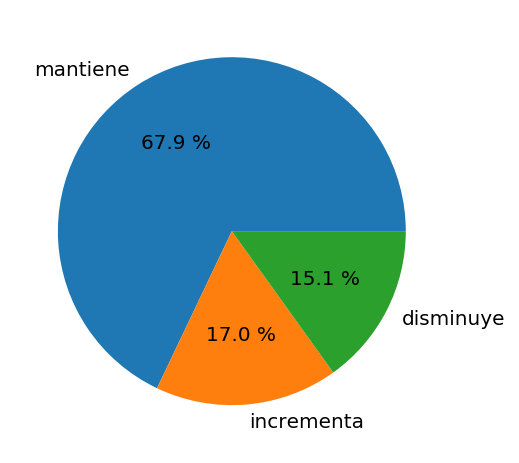

In [45]:
plt.pie(pd.Series(cuenta), labels=df_values["category"].unique(), autopct="%0.1f %%")
plt.show()

In [46]:
grafica = df_values
def categorizar(fila):
    cat = fila.category  
    if cat == "mantiene":
        return 0
    elif cat == "incrementa":
        return 1
    else:
        return -1
grafica["y"] = grafica.apply(categorizar, axis=1) # se categoriza los valores de y en (-1,0,1)


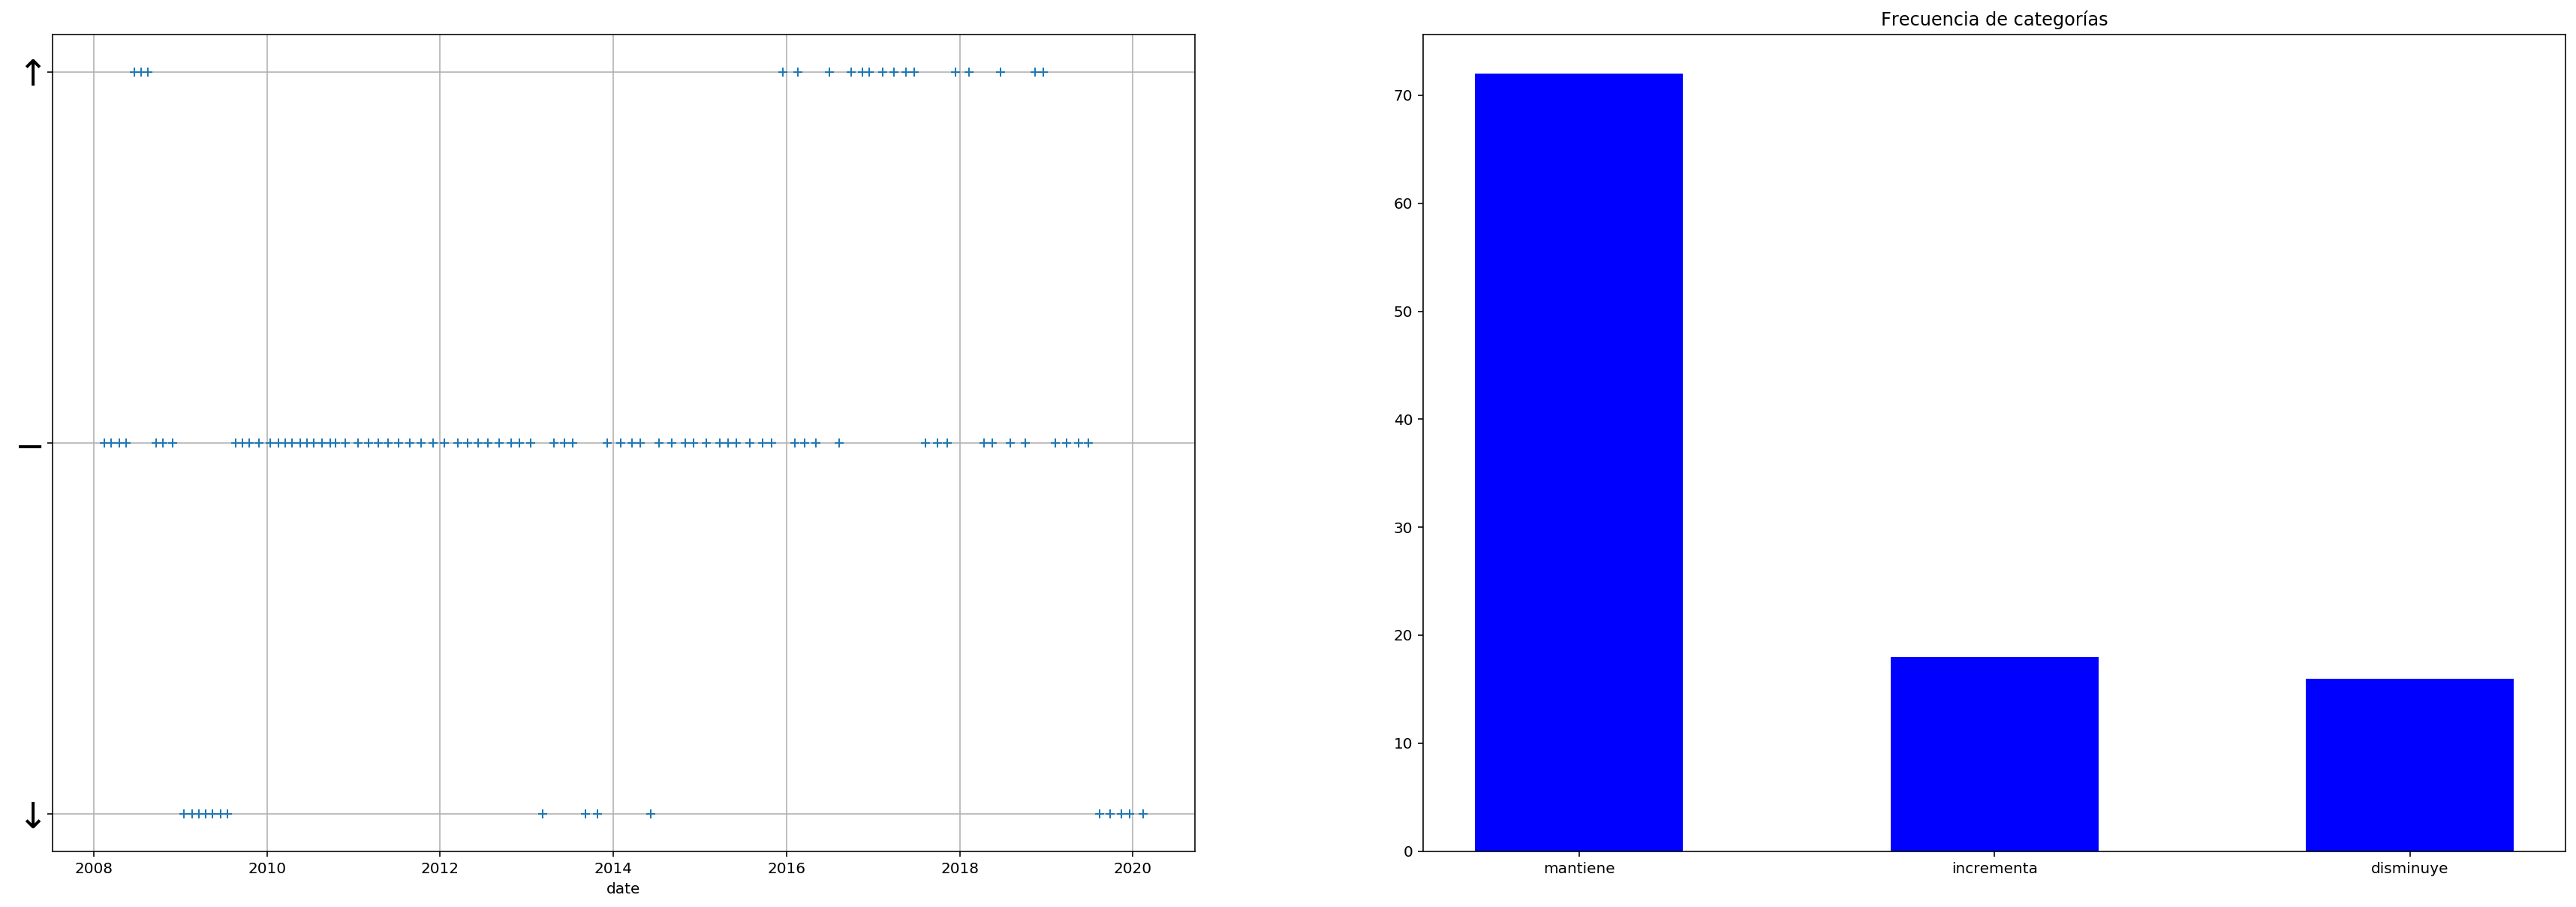

In [48]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(30,10))
plt.subplot2grid((1,2),(0,0))
plt.plot(grafica["y"],linestyle="", marker = "+")
plt.yticks([-1,0,1],[r'$\downarrow$',r'$-$',r'$\uparrow$'],fontsize=24)
plt.xlabel("date")
plt.grid(True)


plt.subplot2grid((1,2),(0,1))
plt.bar(grafica["category"].unique(),df_values["category"].value_counts(), width = 0.50,color ="blue")
plt.title("Frecuencia de categorías")
plt.show()

In [49]:
grafica["año"] = list(pd.to_datetime(grafica.index.values).strftime('%Y'))
grafica.groupby(["año","category"]).count()["url"][:10]


año   category  
2008  incrementa     3
      mantiene       7
2009  disminuye      7
      mantiene       4
2010  mantiene      11
2011  mantiene       8
2012  mantiene       8
2013  disminuye      3
      mantiene       5
2014  disminuye      1
Name: url, dtype: int64

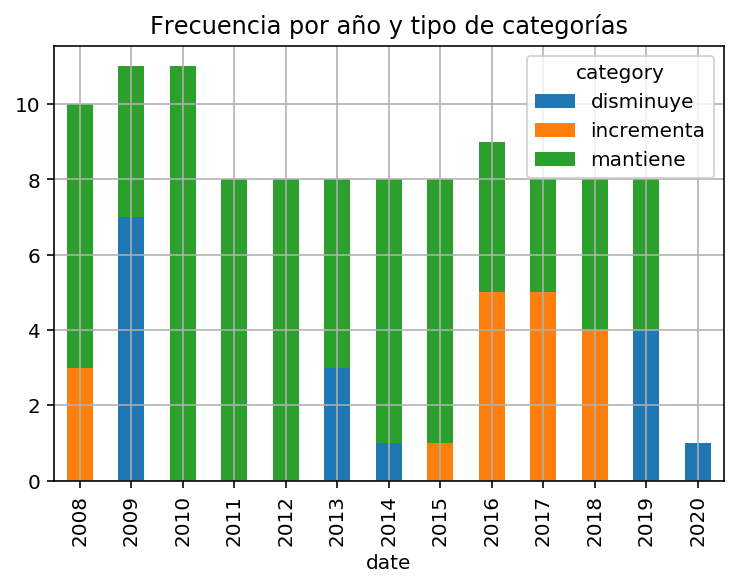

In [50]:
grafico2 = grafica.groupby(["año","category"]).count()["url"]
grafico2.unstack().plot(kind='bar', stacked=True)
plt.xlabel("date")
plt.title("Frecuencia por año y tipo de categorías")
plt.grid(True)

# Descargando y guardadando pdf

In [25]:
import requests
import re
#re.search(r"The E\..",  df_values.url[0])
ruta = "C:/users/José Miguel/descargas_minutas"
for i in range(len(df_values.url)-1): #la última no es anuncio
    url = df_values.url[i] #extraigo la url del dataframe
    myfile = requests.get(url) #leo la url
    fecha = list(pd.to_datetime(grafica.index.values).strftime('%Y%m%d'))[i] #extraigo la fecha correspondiente
    pdf = fecha + re.findall("{[^\?]+", df_values.url[i])[0] #extraigo el nombre del archivo y concateno con fecha
    full_path = os.path.join(ruta,pdf) #"paper.pdf"
    open(full_path, 'wb').write(myfile.content) #escribo el archivo en la computadora

In [24]:
!pip install pypdf2


In [21]:
from PyPDF2 import PdfFileReader
from collections import defaultdict
from os import listdir

In [306]:
texto_fechas = defaultdict(list)


In [307]:
for i in range(len(df_values.url)-1): #el último docuemento se refiere a un calendario, por lo que no se debe tomar
    #fecha = list(pd.to_datetime(grafica.index.values).strftime('%Y%m%d'))[i]
    cat = grafica["category"][i]
    #fecha = list(pd.to_datetime(grafica.index.values).strftime('%Y%m%d'))[i]
    archivo_pdf =listdir(ruta)[i]
    full_path2 = os.path.join(ruta,archivo_pdf)
    with open(full_path2, 'rb') as f:
        pdf = PdfFileReader(f)
        page = pdf.getPage(0)
        page_content = page.extractText()
    
    texto_fechas[cat].append(page_content)
    

In [303]:
del texto_fechas

In [308]:
for key in texto_fechas.keys():
    print(key)   
    

mantiene
incrementa
disminuye


# Naïve  Bayes


In [266]:
import re
def limpia_dialogo(doc): #pasa todo a minusculas
    limpio = doc.lower()
    limpio = re.sub("[^\w ]", "", limpio)
    return limpio

def quita_dialogo(doc): #quita las palabras de las clases
    limpio = doc.lower()
    quita = re.sub("mantener|aumentar|reducir|mexico|", "", limpio)
    return quita

def quita_anio(doc): #quita las palabras de las clases
    limpio = doc.lower()
    quita = re.sub("2008|2009|2010|2011|20012|2013|2014|2015|2016|2017|2018|2019", "", limpio)
    return quita   

In [309]:
texto_fechas["mantiene"] = [limpia_dialogo(doc) for doc in texto_fechas["mantiene"]]
texto_fechas["incrementa"] = [limpia_dialogo(doc) for doc in texto_fechas["incrementa"]]
texto_fechas["disminuye"] = [limpia_dialogo(doc) for doc in texto_fechas["disminuye"]]

texto_fechas["mantiene"] = [quita_dialogo(doc) for doc in texto_fechas["mantiene"]]
texto_fechas["incrementa"] = [quita_dialogo(doc) for doc in texto_fechas["incrementa"]]
texto_fechas["disminuye"] = [quita_dialogo(doc) for doc in texto_fechas["disminuye"]]



In [122]:
from unidecode import unidecode
from nltk import corpus
import nltk
nltk.download("stopwords")
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\B13610\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [310]:
D1_train, D1_test = train_test_split(texto_fechas["mantiene"], test_size=0.2)
D2_train, D2_test = train_test_split(texto_fechas["incrementa"], test_size=0.2)
D3_train, D3_test = train_test_split(texto_fechas["disminuye"], test_size=0.2)

In [311]:
stopwords = corpus.stopwords.words("spanish")
stopwords = [unidecode(word) for word in stopwords]


In [312]:
len(D1_train)
len(texto_fechas["mantiene"])

72

In [313]:
V1 = [palabra for dialogo in D1_train for palabra in dialogo.split()
      if palabra not in stopwords]
V2 = [palabra for dialogo in D2_train for palabra in dialogo.split()
      if palabra not in stopwords]
V3 = [palabra for dialogo in D3_train for palabra in dialogo.split()
      if palabra not in stopwords]

In [314]:
palabras_fin = pd.DataFrame()
palabras_fin["mantiene"] = pd.Series(len(set(V1)) / len(V1))
palabras_fin["disminuye"] = pd.Series(len(set(V2)) / len(V2))
palabras_fin["aumenta"] = pd.Series(len(set(V3)) / len(V3))
palabras_fin

,mantiene,disminuye,aumenta
0,0.128968,0.274255,0.289676


In [315]:
#posible interseccion de las palabras
top_words= pd.DataFrame()
top_words["mantiene"]= pd.Series(V3).value_counts()[:10] #disminuye
top_words["disminuye"]= pd.Series(V1).value_counts()[:10] #mantiene
top_words["incrementa"]= pd.Series(V2).value_counts()[:10]
top_words

,mantiene,disminuye,incrementa
inflación,52,315.0,49.0
economía,38,170.0,45.0
crecimiento,36,179.0,39.0
monetaria,35,168.0,51.0
méxico,34,170.0,40.0
riesgos,33,NaN,NaN
económica,33,143.0,44.0
actividad,31,159.0,40.0
política,28,134.0,49.0
interés,27,NaN,38.0


In [316]:
pd.Series(V1).value_counts() #mantiene

inflación       315
crecimiento     179
economía        170
méxico          170
monetaria       168
               ... 
reforzada         1
restrictivas      1
evidente          1
dará              1
existencia        1
Length: 2275, dtype: int64

In [296]:
pd.Series(V2).value_counts() #incrementa

monetaria      161
política       154
inflación      139
economía       137
crecimiento    132
              ... 
semana           1
tornó            1
lograrlo         1
fuentes          1
argumentos       1
Length: 1304, dtype: int64

In [320]:
pd.Series(V3).value_counts() #disminuye

inflación      52
economía       38
crecimiento    36
monetaria      35
méxico         34
               ..
impactaron      1
efectividad     1
mínimos         1
acumulado       1
operaría        1
Length: 982, dtype: int64

In [318]:
V = set(V1) | set(V2) |set(V3)
vocab = pd.DataFrame(index=V)
V1_c = pd.Series(V1, name="k1").value_counts()
V2_c = pd.Series(V2, name="k2").value_counts()
V3_c = pd.Series(V2, name="k3").value_counts()

In [321]:
# likelihood
L = (vocab.join(V1_c, how="left")
          .join(V2_c, how="left").join(V3_c,how="left"))
#L = vocab.join(V3_c, how= "left")

L = L.fillna(0) + 1
L = L / L.sum(axis=0)
L.sample(10, random_state=314)

,k1,k2,k3
relajado,0.000049,0.000146,0.000146
dicha,0.001036,0.000876,0.000876
persistir,0.000099,0.000146,0.000146
divisas,0.000296,0.000292,0.000292
análisis,0.000099,0.000146,0.000146
presidida,0.000099,0.000146,0.000146
327,0.000049,0.000146,0.000146
responsabilidad,0.000099,0.000146,0.000146
prensa,0.002912,0.002336,0.002336
próximos,0.000592,0.000438,0.000438


In [322]:
log_L = np.log(L)
N= len(D1_train)+len(D2_train)+len(D3_train)
log_prior_k1 = np.log(len(D1_train) / N)
log_prior_k2 = np.log(len(D2_train) / N)
log_prior_k3 = np.log(len(D3_train) / N)
log_priors = np.array([log_prior_k1, log_prior_k2, log_prior_k3])

In [323]:
D_test = D1_test + D2_test + D3_test
y_test = ["k1"] * len(D1_test) + ["k2"] * len(D2_test)+["k3"] * len(D3_test)
yhat_test = []
for d_test in D_test:
    f = set([palabra for palabra in d_test.split() if palabra in V])
    res = log_L.loc[f].sum(axis=0) + log_priors
    yhat_test.append(res.idxmax())

In [324]:
y_test = ["k1"] * len(D1_test) + ["k2"] * len(D2_test)+["k3"] * len(D3_test)
casos = pd.DataFrame()
casos["y_test"] = y_test
casos["y_hat"] = yhat_test
casos


,y_test,y_hat
0,k1,k1
1,k1,k1
2,k1,k1
3,k1,k2
4,k1,k1
5,k1,k1
6,k1,k1
7,k1,k2
8,k1,k1
9,k1,k1


In [329]:
from sklearn.metrics import confusion_matrix
data = confusion_matrix(y_test, yhat_test)
data

array([[12,  3,  0],
       [ 2,  2,  0],
       [ 3,  0,  0]], dtype=int64)

In [326]:
import seaborn as sn

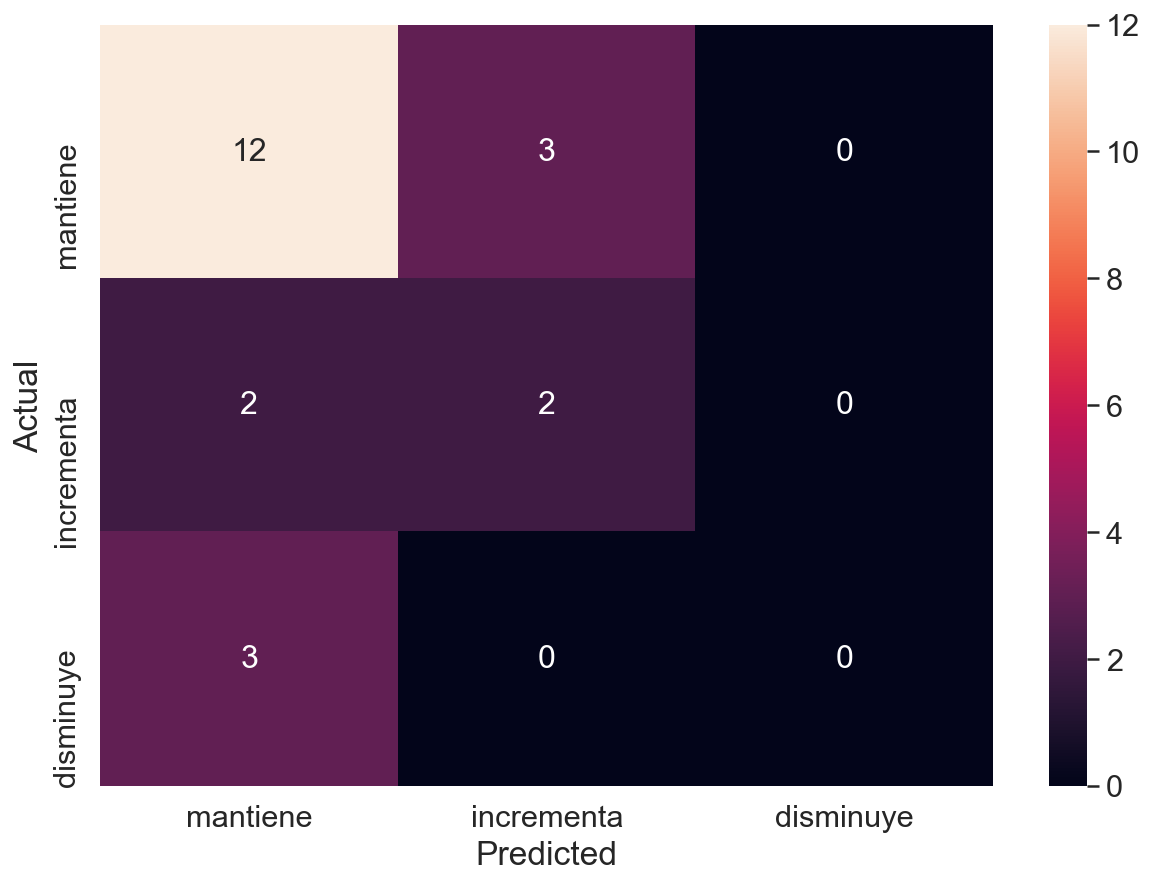

In [338]:
data = [[12,  3,  0],
       [ 2,  2,  0],
       [ 3,  0,  0]]

conf = pd.DataFrame(data, columns=["mantiene","incrementa","disminuye"], index = ["mantiene","incrementa","disminuye"])
conf.index.name = 'Actual'
conf.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(conf, annot=True, annot_kws={"size": 16}) 
plt.show()